### Convert tobacco dataset to yolo format

In [145]:
# importing dependencies
import os
from glob import glob
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection
import cv2

In [156]:
BASE_DIR = '../../assets/tobacco_800'
DATASET_DIR = BASE_DIR + '/dataset'
GROUND_TRUTH_DIR = BASE_DIR + '/ground_truth'
TEMP_DIR = BASE_DIR + '/temp'
TRAIN_LABEL_DIR = BASE_DIR + '/processed/train/label'
TRAIN_IMAGE_DIR = BASE_DIR + '/processed/train/image'
TEST_LABEL_DIR = BASE_DIR + '/processed/test/label'
TEST_IMAGE_DIR = BASE_DIR + '/processed/test/image'

In [147]:
# create empty data frame to store the data
df = pd.DataFrame(columns=["file_name", "new_name", "page_height", "page_width", "x", "y", "w", "h"])

In [148]:
# act as a counter for the number of images
cnt = 0
rows = []

annotations = glob(GROUND_TRUTH_DIR + '/*.xml')
for file in annotations:
    root = ET.parse(file).getroot()
    file_name = root[0].attrib["src"]

    # dataset has some documents with no labels, ignoring them
    if (len(root[0][0]) == 0):
        continue

    # set new name of the file to cnt.jpg, conversion happens later
    new_name = str(cnt) + ".jpg"

    # page dimensions
    page_width = int(root[0][0].attrib["width"])
    page_height = int(root[0][0].attrib["height"])

    increase_cnt = False

    for zone in root[0][0]:
        category = zone.attrib["gedi_type"]

        # accept only signatures
        if (category != "DLSignature"):
            continue

        id = zone.attrib["id"]
        overlapped = zone.attrib["Overlapped"]

        # dimensions of the bounding box
        x = zone.attrib["col"]
        y = zone.attrib["row"]
        w = zone.attrib["width"]
        h = zone.attrib["height"]

        # append the data to the data frame
        rows.append({"file_name": file_name, "new_name": new_name, "page_height": page_height, "page_width": page_width, "x": x, "y": y, "w": w, "h": h})

        increase_cnt = True
    
    if (increase_cnt):
        cnt += 1

In [149]:
# create a data frame from the list of rows
df = pd.DataFrame(rows, columns=["file_name", "new_name", "page_height", "page_width", "x", "y", "w", "h"])

df

,file_name,new_name,page_height,page_width,x,y,w,h
0,aah97e00-page02_2.tif,0.jpg,3296,2560,1409,793,659,361
1,aam09c00.tif,1.jpg,2292,1728,821,1422,757,183
2,aao54e00_2.tif,2.jpg,3296,2560,1514,708,627,206
3,abm69c00.tif,3.jpg,2292,1728,667,1279,617,110
4,acr64d00.tif,4.jpg,2292,1728,886,1801,463,181
...,...,...,...,...,...,...,...,...
905,zrt45f00.tif,771.jpg,1575,1200,514,1019,278,48
906,zrz94a00-page02_2.tif,772.jpg,2156,1728,828,1046,362,91
907,zss86d00.tif,773.jpg,2292,1728,867,1734,363,189
908,ztz52d00-page02_2.tif,774.jpg,2292,1728,896,651,205,178


Scale down the images to 640x480 max to save training time

In [150]:
MAX_HEIGHT = 640
MAX_WIDTH = 480

try:
    os.mkdir(TEMP_DIR)
except:
    pass

unique_files = df.drop_duplicates("file_name")
for iter in unique_files.iterrows():
    row = iter[1]

    # compute the scaling factor
    scale = min(MAX_HEIGHT / row["page_height"], MAX_WIDTH / row["page_width"])

    # if the image is smaller than the max dimensions, then no need to resize
    if (scale > 1):
        continue

    # read the image
    img = cv2.imread(DATASET_DIR + "/" + row["file_name"], 1)

    # resize the image
    img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    # save the image
    cv2.imwrite(TEMP_DIR + "/" + row["new_name"], img)

    # update the data frame
    df.loc[df["file_name"] == row["file_name"], "page_height"] = img.shape[0]
    df.loc[df["file_name"] == row["file_name"], "page_width"] = img.shape[1]
    df.loc[df["file_name"] == row["file_name"], "x"] = df.loc[df["file_name"] == row["file_name"], "x"].astype(int) * scale
    df.loc[df["file_name"] == row["file_name"], "y"] = df.loc[df["file_name"] == row["file_name"], "y"].astype(int) * scale
    df.loc[df["file_name"] == row["file_name"], "w"] = df.loc[df["file_name"] == row["file_name"], "w"].astype(int) * scale
    df.loc[df["file_name"] == row["file_name"], "h"] = df.loc[df["file_name"] == row["file_name"], "h"].astype(int) * scale

df


,file_name,new_name,page_height,page_width,x,y,w,h
0,aah97e00-page02_2.tif,0.jpg,618,480,264.1875,148.6875,123.5625,67.6875
1,aam09c00.tif,1.jpg,637,480,228.055556,395.0,210.277778,50.833333
2,aao54e00_2.tif,2.jpg,618,480,283.875,132.75,117.5625,38.625
3,abm69c00.tif,3.jpg,637,480,185.277778,355.277778,171.388889,30.555556
4,acr64d00.tif,4.jpg,637,480,246.111111,500.277778,128.611111,50.277778
...,...,...,...,...,...,...,...,...
905,zrt45f00.tif,771.jpg,630,480,205.6,407.6,111.2,19.2
906,zrz94a00-page02_2.tif,772.jpg,599,480,230.0,290.555556,100.555556,25.277778
907,zss86d00.tif,773.jpg,637,480,240.833333,481.666667,100.833333,52.5
908,ztz52d00-page02_2.tif,774.jpg,637,480,248.888889,180.833333,56.944444,49.444444


Validate scaled image

240.375 309.9375 104.0625 51.75


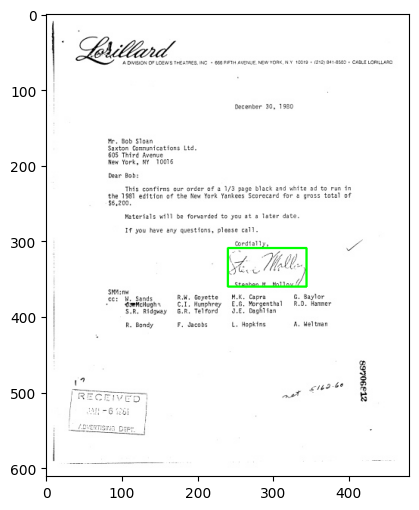

In [151]:
random_row = df.sample(1)

# read the image
img = cv2.imread(TEMP_DIR + "/" + random_row.iloc[0]["new_name"])
print(random_row.iloc[0]["x"], random_row.iloc[0]["y"], random_row.iloc[0]["w"], random_row.iloc[0]["h"])
img = cv2.rectangle(img, (int(random_row.iloc[0]["x"]), int(random_row.iloc[0]["y"])), (int(random_row.iloc[0]["x"]) + int(random_row.iloc[0]["w"]), int(random_row.iloc[0]["y"]) + int(random_row.iloc[0]["h"])), (0, 255, 0), 2)

# show the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.show()

Yolo requires the data to be in a specific format. The format is as follows:

* Each image is in a separate folder

* Each image has a corresponding .txt file with the same name

* The .txt file contains the bounding box coordinates and class for each object in the image

The .txt file is formatted as follows:

* Each row contains the class number and the bounding box coordinates for one object

* The class number is an integer between 0 and (classes-1)

* The bounding box coordinates are floats between 0 and 1 and represent the center x, center y, width, and height of the bounding box relative to the width and height of the image

* The bounding box coordinates must be rescaled to be between 0 and the width or height of the resized image



In [152]:
def x_center(row):
    return row["x"] + row["w"] / 2

def y_center(row):
    return row["y"] + row["h"] / 2

df["x_center"] = df.apply(x_center, axis=1)
df["y_center"] = df.apply(y_center, axis=1)

def x_center_norm(row):
    return row["x_center"] / row["page_width"]

def y_center_norm(row):
    return row["y_center"] / row["page_height"]

def w_norm(row):
    return row["w"] / row["page_width"]

def h_norm(row):
    return row["h"] / row["page_height"]

df["x_center_norm"] = df.apply(x_center_norm, axis=1)
df["y_center_norm"] = df.apply(y_center_norm, axis=1)
df["w_norm"] = df.apply(w_norm, axis=1)
df["h_norm"] = df.apply(h_norm, axis=1)

df

,file_name,new_name,page_height,page_width,x,y,w,h,x_center,y_center,x_center_norm,y_center_norm,w_norm,h_norm
0,aah97e00-page02_2.tif,0.jpg,618,480,264.1875,148.6875,123.5625,67.6875,325.968750,182.531250,0.679102,0.295358,0.257422,0.109527
1,aam09c00.tif,1.jpg,637,480,228.055556,395.0,210.277778,50.833333,333.194444,420.416667,0.694155,0.659995,0.438079,0.079801
2,aao54e00_2.tif,2.jpg,618,480,283.875,132.75,117.5625,38.625,342.656250,152.062500,0.713867,0.246056,0.244922,0.062500
3,abm69c00.tif,3.jpg,637,480,185.277778,355.277778,171.388889,30.555556,270.972222,370.555556,0.564525,0.581720,0.357060,0.047968
4,acr64d00.tif,4.jpg,637,480,246.111111,500.277778,128.611111,50.277778,310.416667,525.416667,0.646701,0.824830,0.267940,0.078929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,zrt45f00.tif,771.jpg,630,480,205.6,407.6,111.2,19.2,261.200000,417.200000,0.544167,0.662222,0.231667,0.030476
906,zrz94a00-page02_2.tif,772.jpg,599,480,230.0,290.555556,100.555556,25.277778,280.277778,303.194444,0.583912,0.506168,0.209491,0.042200
907,zss86d00.tif,773.jpg,637,480,240.833333,481.666667,100.833333,52.5,291.250000,507.916667,0.606771,0.797357,0.210069,0.082418
908,ztz52d00-page02_2.tif,774.jpg,637,480,248.888889,180.833333,56.944444,49.444444,277.361111,205.555556,0.577836,0.322693,0.118634,0.077621


Splitting the data into train and test

In [153]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=7, shuffle=True)
print(df_train.shape, df_valid.shape)

(819, 14) (91, 14)


In [157]:
try:
    os.makedirs(TRAIN_LABEL_DIR)
    os.makedirs(TRAIN_IMAGE_DIR)
    os.makedirs(TEST_IMAGE_DIR)
    os.makedirs(TEST_LABEL_DIR)
except:
    pass

Segregate the data into train and test

In [159]:
import shutil

for iter in df_train.iterrows():
    row = iter[1]

    # copy the image
    shutil.copy(TEMP_DIR + "/" + row["new_name"], TRAIN_IMAGE_DIR + "/" + row["new_name"])

    # create the label file
    with open(TRAIN_LABEL_DIR + "/" + row["new_name"].replace(".jpg", ".txt"), "w") as f:
        f.write("0 {} {} {} {}".format(row["x_center_norm"], row["y_center_norm"], row["w_norm"], row["h_norm"]))

for iter in df_valid.iterrows():
    row = iter[1]

    # copy the image
    shutil.copy(TEMP_DIR + "/" + row["new_name"], TEST_IMAGE_DIR + "/" + row["new_name"])

    # create the label file
    with open(TEST_LABEL_DIR + "/" + row["new_name"].replace(".jpg", ".txt"), "w") as f:
        f.write("0 {} {} {} {}".format(row["x_center_norm"], row["y_center_norm"], row["w_norm"], row["h_norm"]))

In [160]:
print("No of training images: ", len(os.listdir(TRAIN_IMAGE_DIR)))
print("No of training labels: ", len(os.listdir(TRAIN_LABEL_DIR)))
print("No of test images: ", len(os.listdir(TEST_IMAGE_DIR)))
print("No of test labels: ", len(os.listdir(TEST_LABEL_DIR)))

No of training images:  705
No of training labels:  705
No of test images:  89
No of test labels:  89


In [161]:
# delete the temporary directory
shutil.rmtree(TEMP_DIR)